In [1]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [2]:
file_path = 'PROCESSED_DryBeanDataSet.xlsx'
df = pd.read_excel(file_path)
df.shape

(24778, 24)

In [3]:
### KNN BELOW

In [4]:
# Assuming 'Class' is the target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.shape

(24778, 23)

In [5]:
# Initialize the model
knn = KNeighborsClassifier(n_neighbors=5)

# Get the initial list of features
features = X_train.columns.tolist()
n_features = len(features)

# Initialize variables to store the best feature subset
best_features = features
best_score = 0

# Start backward selection
while len(features) > 1:
    scores = []
    for feature in features:
        # Temporarily drop one feature
        X_train_subset = X_train[features].drop(columns=[feature])
        X_test_subset = X_test[features].drop(columns=[feature])

        # Train the KNN model on the remaining features
        knn.fit(X_train_subset, y_train)
        y_pred = knn.predict(X_test_subset)
        
        # Evaluate using accuracy
        score = accuracy_score(y_test, y_pred)
        scores.append((score, feature))
    
    # Find the feature whose removal leads to the highest accuracy
    scores.sort()
    best_feature_to_remove = scores[-1][1]
    best_score_current = scores[-1][0]
    
    # If current best score is better than the overall best, update best_features
    if best_score_current > best_score:
        best_score = best_score_current
        features.remove(best_feature_to_remove)
        best_features = features[:]
    else:
        # Stop if removing more features doesn't improve the model
        break

print("Best features:", best_features)
print("Best score achieved:", best_score)

# Final model training on best feature subset
knn.fit(X_train[best_features], y_train)
final_score = knn.score(X_test[best_features], y_test)
print("Final model accuracy on test set:", final_score)

Best features: ['Colour_brown', 'Colour_green', 'Colour_white', 'Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'ConvexArea', 'Constantness', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor5', 'Sort order']
Best score achieved: 0.9903147699757869
Final model accuracy on test set: 0.9903147699757869


In [6]:
len(best_features)

18

In [7]:
X = df.drop('Class', axis=1)
y = df['Class']

# Assuming 'best_features' contains the list of selected features
# e.g., best_features = ['feature1', 'feature2', 'feature3']

# Filter X to include only the best features
X_best = X[best_features]

# Split into train and test sets using only the best features
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.3, random_state=42)


In [8]:
X_train.shape

(17344, 18)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Assuming 'X_train_best' and 'y_train' are your training data after backward subset selection

# Define a range of k values to test
k_range = range(1, 31)  # Testing k values from 1 to 30
k_scores = []

# Perform cross-validation for each k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

# Find the optimal k (the one with the highest cross-validated accuracy)
optimal_k = k_range[np.argmax(k_scores)]
print(f"The optimal k value is: {optimal_k}")

The optimal k value is: 1


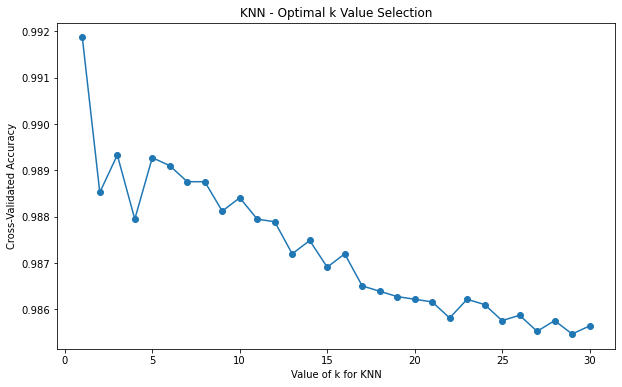

Final model accuracy on the test set: 0.9895076674737692


In [10]:
# Plotting the relationship between k and the cross-validated accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o')
plt.xlabel('Value of k for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN - Optimal k Value Selection')
plt.show()

# Train the final model with the optimal k
optimal_k = 5
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = knn_optimal.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final model accuracy on the test set: {final_accuracy}")

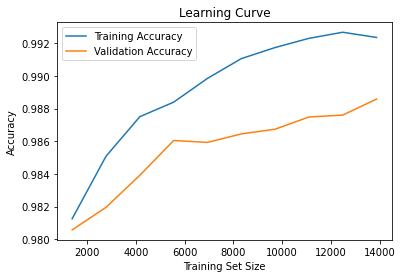

In [11]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, valid_scores = learning_curve(
    knn_optimal, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [12]:
# Define k-fold cross-validation procedure
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(knn_optimal, X, y, cv=kf, scoring='accuracy')

# Print the results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.5f}")
print(f"Standard Deviation of Accuracy: {np.std(cv_scores):.5f}")

Cross-Validation Scores: [0.98587571 0.98829701 0.98870056 0.98668012 0.9889001 ]
Mean Accuracy: 0.98769
Standard Deviation of Accuracy: 0.00120


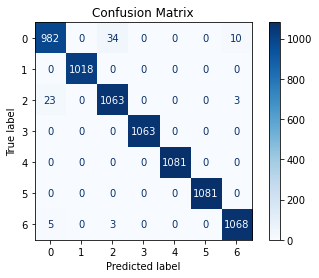

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions using the pruned tree
y_pred = knn_optimal.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=knn_optimal.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_optimal.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')

plt.title('Confusion Matrix')
plt.show()

In [14]:
from sklearn.metrics import classification_report
# Make predictions using the pruned tree
y_pred = knn_optimal.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred, labels=knn_optimal.classes_, output_dict=True)

# Convert to DataFrame for better control over formatting
df_report = pd.DataFrame(report).transpose()

# Format DataFrame to display 5 decimal places
pd.options.display.float_format = '{:,.5f}'.format

print("Classification Report with 5 Decimal Places:")
print(df_report)

Classification Report with 5 Decimal Places:
              precision  recall  f1-score     support
0               0.97228 0.95712   0.96464 1,026.00000
1               1.00000 1.00000   1.00000 1,018.00000
2               0.96636 0.97612   0.97122 1,089.00000
3               1.00000 1.00000   1.00000 1,063.00000
4               1.00000 1.00000   1.00000 1,081.00000
5               1.00000 1.00000   1.00000 1,081.00000
6               0.98797 0.99257   0.99026 1,076.00000
accuracy        0.98951 0.98951   0.98951     0.98951
macro avg       0.98952 0.98940   0.98945 7,434.00000
weighted avg    0.98951 0.98951   0.98949 7,434.00000


In [15]:
#####TREE MODEL BELOW

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Assuming you have already preprocessed your dataset
# X is your feature matrix, and y is your target variable

# Example data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
decision_tree = DecisionTreeClassifier(random_state=42)

# Get the initial list of features
features = X_train.columns.tolist()
n_features = len(features)

# Initialize variables to store the best feature subset
best_features = features
best_score = 0

# Start backward selection
while len(features) > 1:
    scores = []
    for feature in features:
        # Temporarily drop one feature
        X_train_subset = X_train[features].drop(columns=[feature])
        X_test_subset = X_test[features].drop(columns=[feature])

        # Train the Decision Tree model on the remaining features
        decision_tree.fit(X_train_subset, y_train)
        y_pred = decision_tree.predict(X_test_subset)
        
        # Evaluate using accuracy
        score = accuracy_score(y_test, y_pred)
        scores.append((score, feature))
    
    # Find the feature whose removal leads to the highest accuracy
    scores.sort()
    best_feature_to_remove = scores[-1][1]
    best_score_current = scores[-1][0]
    
    # If current best score is better than the overall best, update best_features
    if best_score_current > best_score:
        best_score = best_score_current
        features.remove(best_feature_to_remove)
        best_features = features[:]
    else:
        # Stop if removing more features doesn't improve the model
        break

print("Best features:", best_features)
print("Best score achieved:", best_score)

# Final model training on best feature subset
decision_tree.fit(X_train[best_features], y_train)
final_score = decision_tree.score(X_test[best_features], y_test)
print("Final model accuracy on test set:", final_score)

Best features: ['Colour_brown', 'Colour_green', 'Colour_white', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'Constantness', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor3', 'ShapeFactor5', 'ShapeFactor6', 'Sort order']
Best score achieved: 0.9882970137207425
Final model accuracy on test set: 0.9882970137207425


In [17]:
len(best_features)

20

In [18]:
X = df.drop('Class', axis=1)
y = df['Class']

# Assuming 'best_features' contains the list of selected features
# e.g., best_features = ['feature1', 'feature2', 'feature3']

# Filter X to include only the best features
X_best = X[best_features]

# Split into train and test sets using only the best features
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.3, random_state=42)


In [19]:
# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print(f"Tree Depth: {clf.get_depth()}")
print(f"Number of Leaves: {clf.get_n_leaves()}")

Model Accuracy: 0.9844
Tree Depth: 18
Number of Leaves: 194


In [20]:
X_train.shape

(17344, 20)

In [30]:
# Train the full tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get the effective alphas and corresponding total leaf impurities (impurities sum)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Perform cross-validation for each alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Determine the best alpha using cross-validation
alpha_scores = [cross_val_score(clf, X_train, y_train, cv=5).mean() for clf in clfs]
best_alpha = ccp_alphas[np.argmax(alpha_scores)]

# Prune the tree with the best alpha
pruned_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0002203053103509646, random_state=42)

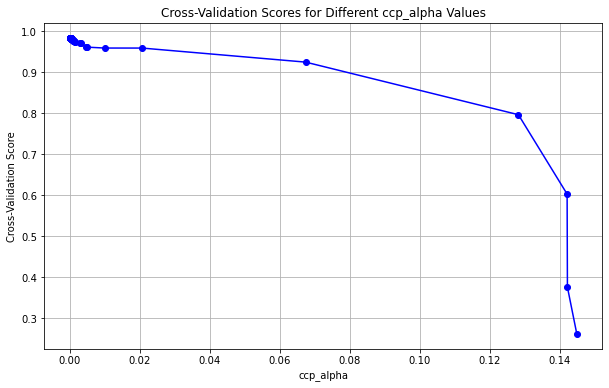

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Train the full tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get the effective alphas and corresponding total leaf impurities (impurities sum)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Perform cross-validation for each alpha
clfs = []
alpha_scores = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    cv_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    alpha_scores.append(cv_score)

# Determine the best alpha using cross-validation
best_alpha = ccp_alphas[np.argmax(alpha_scores)]

# Prune the tree with the best alpha
pruned_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_clf.fit(X_train, y_train)

# Plot ccp_alpha vs. cross-validation score
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, alpha_scores, marker='o', linestyle='-', color='blue')
plt.xlabel('ccp_alpha')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Scores for Different ccp_alpha Values')
plt.grid(True)
plt.show()


In [31]:
# Make predictions
y_pred = pruned_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"PRUNED Model Accuracy: {accuracy:.4f}")

PRUNED Model Accuracy: 0.9835


In [32]:
print(f"Tree Depth: {pruned_clf.get_depth()}")
print(f"Number of Leaves: {pruned_clf.get_n_leaves()}")

Tree Depth: 11
Number of Leaves: 54


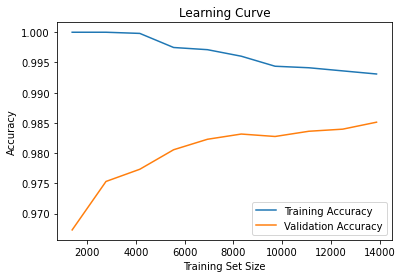

In [33]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, valid_scores = learning_curve(
    pruned_clf, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [34]:
# Define k-fold cross-validation procedure
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(pruned_clf, X, y, cv=kf, scoring='accuracy')

# Print the results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.5f}")
print(f"Standard Deviation of Accuracy: {np.std(cv_scores):.5f}")

Cross-Validation Scores: [0.98527038 0.98325262 0.98567393 0.98567104 0.98506559]
Mean Accuracy: 0.98499
Standard Deviation of Accuracy: 0.00090


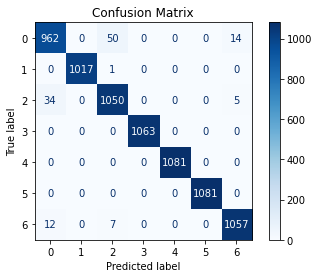

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions using the pruned tree
y_pred = pruned_clf.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pruned_clf.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pruned_clf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')

plt.title('Confusion Matrix')
plt.show()

In [36]:
# Make predictions using the pruned tree
y_pred = pruned_clf.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred, labels=pruned_clf.classes_, output_dict=True)

# Convert to DataFrame for better control over formatting
df_report = pd.DataFrame(report).transpose()

# Format DataFrame to display 5 decimal places
pd.options.display.float_format = '{:,.5f}'.format

print("Classification Report with 5 Decimal Places:")
print(df_report)

Classification Report with 5 Decimal Places:
              precision  recall  f1-score     support
0               0.95437 0.93762   0.94592 1,026.00000
1               1.00000 0.99902   0.99951 1,018.00000
2               0.94765 0.96419   0.95585 1,089.00000
3               1.00000 1.00000   1.00000 1,063.00000
4               1.00000 1.00000   1.00000 1,081.00000
5               1.00000 1.00000   1.00000 1,081.00000
6               0.98234 0.98234   0.98234 1,076.00000
accuracy        0.98345 0.98345   0.98345     0.98345
macro avg       0.98348 0.98331   0.98337 7,434.00000
weighted avg    0.98348 0.98345   0.98345 7,434.00000


In [37]:
#### Model Comparison

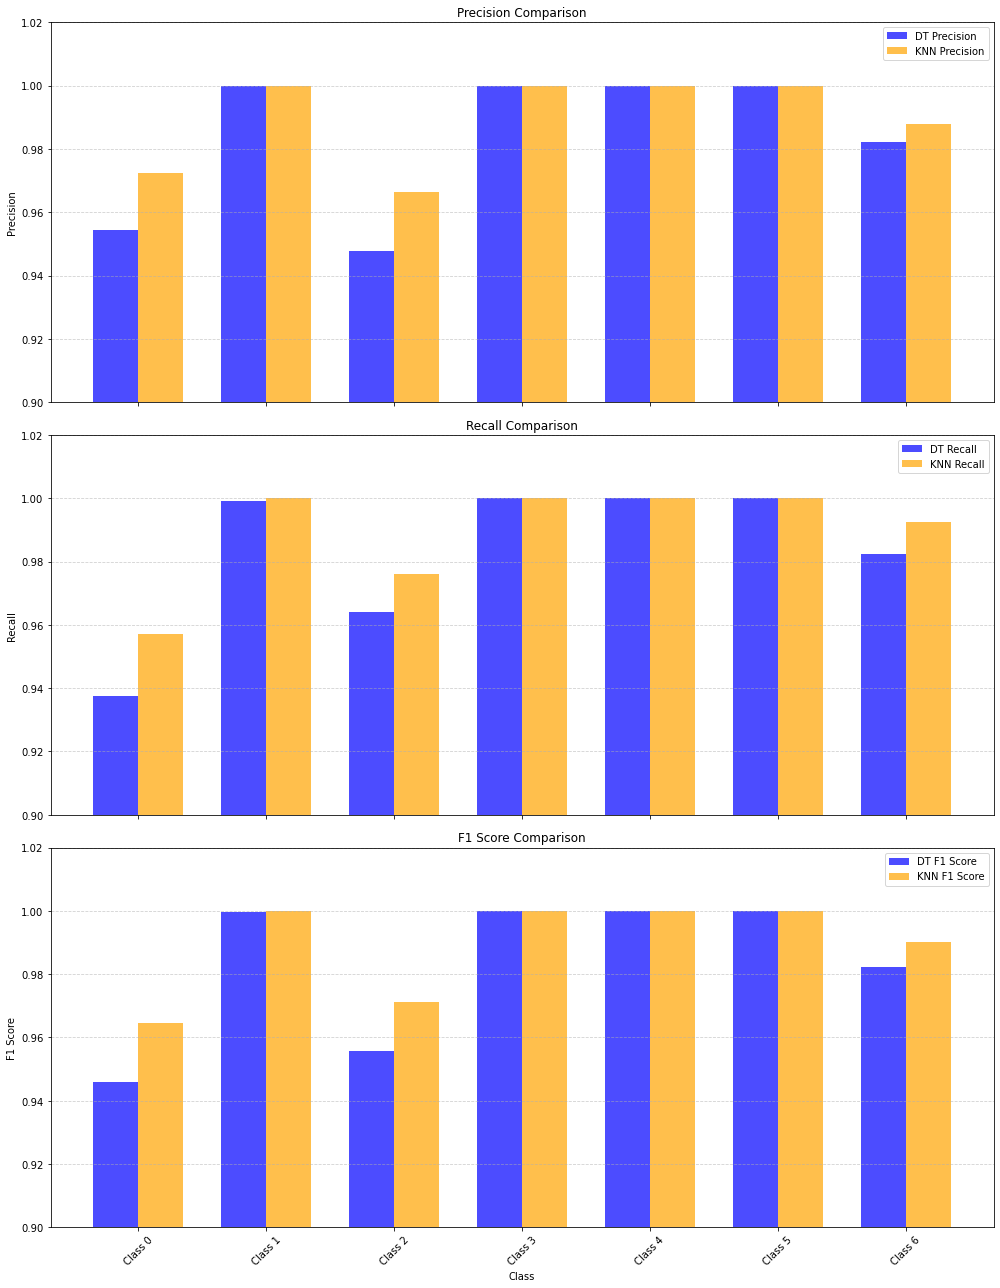

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Decision Tree
dt_precision = [0.95437, 1.00000, 0.94765, 1.00000, 1.00000, 1.00000, 0.98234]
dt_recall = [0.93762, 0.99902, 0.96419, 1.00000, 1.00000, 1.00000, 0.98234]
dt_f1_score = [0.94592, 0.99951, 0.95585, 1.00000, 1.00000, 1.00000, 0.98234]

# Data for KNN
knn_precision = [0.97228, 1.00000, 0.96636, 1.00000, 1.00000, 1.00000, 0.98797]
knn_recall = [0.95712, 1.00000, 0.97612, 1.00000, 1.00000, 1.00000, 0.99257]
knn_f1_score = [0.96464, 1.00000, 0.97122, 1.00000, 1.00000, 1.00000, 0.99026]

# Class names
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']

def plot_comparison():
    x = np.arange(len(class_names))  # the label locations
    width = 0.35  # the width of the bars

    fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

    # Define y-axis limits
    precision_ylim = (0.90, 1.02)
    recall_ylim = (0.90, 1.02)
    f1_score_ylim = (0.90, 1.02)

    # Plot Precision
    axs[0].bar(x - width/2, dt_precision, width, label='DT Precision', color='blue', alpha=0.7)
    axs[0].bar(x + width/2, knn_precision, width, label='KNN Precision', color='orange', alpha=0.7)
    axs[0].set_ylabel('Precision')
    axs[0].set_title('Precision Comparison')
    axs[0].set_ylim(precision_ylim)
    axs[0].legend()
    axs[0].grid(axis='y', linestyle='--', alpha=0.6)

    # Plot Recall
    axs[1].bar(x - width/2, dt_recall, width, label='DT Recall', color='blue', alpha=0.7)
    axs[1].bar(x + width/2, knn_recall, width, label='KNN Recall', color='orange', alpha=0.7)
    axs[1].set_ylabel('Recall')
    axs[1].set_title('Recall Comparison')
    axs[1].set_ylim(recall_ylim)
    axs[1].legend()
    axs[1].grid(axis='y', linestyle='--', alpha=0.6)

    # Plot F1-Score
    axs[2].bar(x - width/2, dt_f1_score, width, label='DT F1 Score', color='blue', alpha=0.7)
    axs[2].bar(x + width/2, knn_f1_score, width, label='KNN F1 Score', color='orange', alpha=0.7)
    axs[2].set_xlabel('Class')
    axs[2].set_ylabel('F1 Score')
    axs[2].set_title('F1 Score Comparison')
    axs[2].set_ylim(f1_score_ylim)
    axs[2].legend()
    axs[2].grid(axis='y', linestyle='--', alpha=0.6)

    plt.xticks(x, class_names, rotation=45)
    plt.tight_layout()
    plt.show()

plot_comparison()


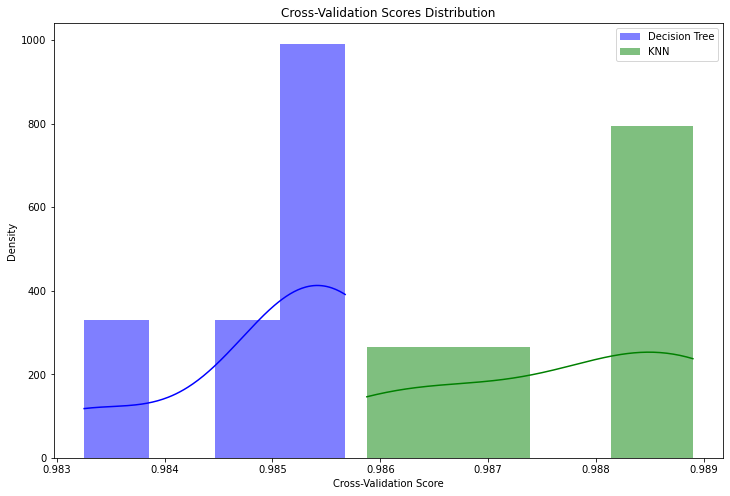

In [39]:
import seaborn as sns

# Data for Cross-Validation Scores
dt_cv_scores = [0.98527038, 0.98325262, 0.98567393, 0.98567104, 0.98506559]
knn_cv_scores = [0.98587571, 0.98829701, 0.98870056, 0.98668012, 0.9889001]

def plot_cv_scores_comparison():
    plt.figure(figsize=(12, 8))
    
    # Plot Cross-Validation Scores
    sns.histplot(dt_cv_scores, color='blue', label='Decision Tree', kde=True, stat='density', linewidth=0)
    sns.histplot(knn_cv_scores, color='green', label='KNN', kde=True, stat='density', linewidth=0)
    
    plt.xlabel('Cross-Validation Score')
    plt.ylabel('Density')
    plt.title('Cross-Validation Scores Distribution')
    plt.legend()
    plt.show()

plot_cv_scores_comparison()


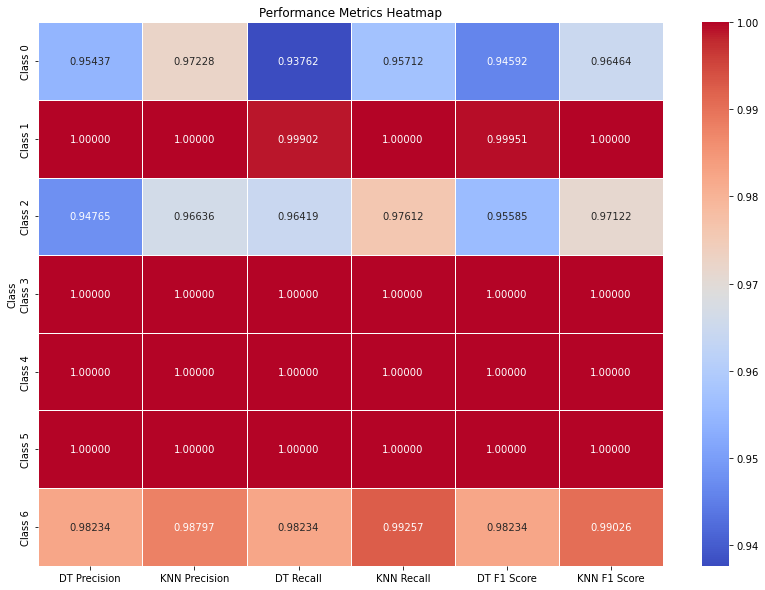

In [40]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for the heatmap
data = {
    'Class': class_names,
    'DT Precision': dt_precision,
    'KNN Precision': knn_precision,
    'DT Recall': dt_recall,
    'KNN Recall': knn_recall,
    'DT F1 Score': dt_f1_score,
    'KNN F1 Score': knn_f1_score
}

df = pd.DataFrame(data).set_index('Class')

plt.figure(figsize=(14, 10))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.5f', linewidths=.5)
plt.title('Performance Metrics Heatmap')
plt.show()


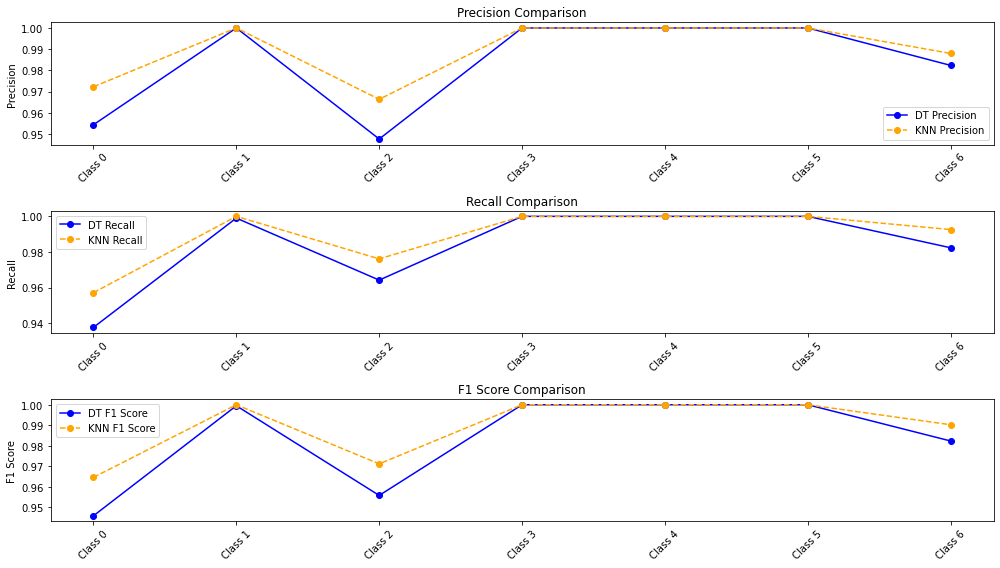

In [41]:
def plot_line_comparison():
    x = np.arange(len(class_names))  # the label locations

    plt.figure(figsize=(14, 8))

    # Plot Precision
    plt.subplot(3, 1, 1)
    plt.plot(x, dt_precision, marker='o', linestyle='-', color='blue', label='DT Precision')
    plt.plot(x, knn_precision, marker='o', linestyle='--', color='orange', label='KNN Precision')
    plt.xticks(x, class_names, rotation=45)
    plt.ylabel('Precision')
    plt.title('Precision Comparison')
    plt.legend()

    # Plot Recall
    plt.subplot(3, 1, 2)
    plt.plot(x, dt_recall, marker='o', linestyle='-', color='blue', label='DT Recall')
    plt.plot(x, knn_recall, marker='o', linestyle='--', color='orange', label='KNN Recall')
    plt.xticks(x, class_names, rotation=45)
    plt.ylabel('Recall')
    plt.title('Recall Comparison')
    plt.legend()

    # Plot F1-Score
    plt.subplot(3, 1, 3)
    plt.plot(x, dt_f1_score, marker='o', linestyle='-', color='blue', label='DT F1 Score')
    plt.plot(x, knn_f1_score, marker='o', linestyle='--', color='orange', label='KNN F1 Score')
    plt.xticks(x, class_names, rotation=45)
    plt.ylabel('F1 Score')
    plt.title('F1 Score Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_line_comparison()


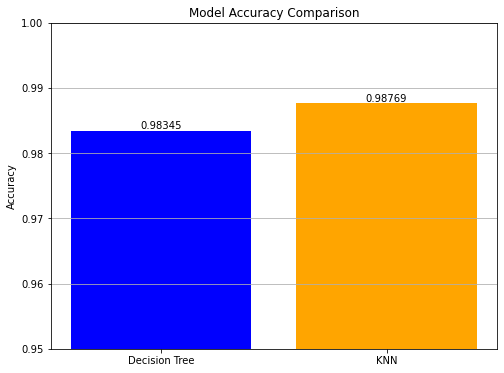

In [42]:
def plot_accuracy_bar_comparison():
    # Accuracy data
    dt_accuracy = 0.98345  # Provided for Decision Tree
    knn_accuracy = 0.98769  # Provided for KNN

    # Plotting
    x = ['Decision Tree', 'KNN']
    accuracies = [dt_accuracy, knn_accuracy]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(x, accuracies, color=['blue', 'orange'])

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.5f}', ha='center', va='bottom')

    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim([0.95, 1.00])
    plt.grid(axis='y')
    plt.show()

plot_accuracy_bar_comparison()


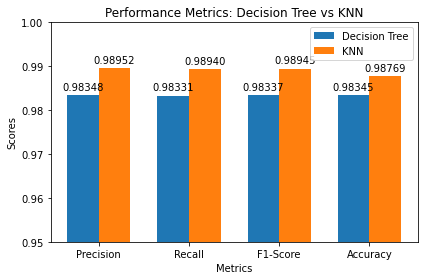

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the metrics (precision, recall, f1-score, accuracy) for both models
labels = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
dtc_metrics = [0.98348, 0.98331, 0.98337, 0.98345]  # Decision Tree metrics
knn_metrics = [0.98952, 0.98940, 0.98945, 0.98769]  # KNN metrics

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dtc_metrics, width, label='Decision Tree')
rects2 = ax.bar(x + width/2, knn_metrics, width, label='KNN')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics: Decision Tree vs KNN')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Set y-axis limits
ax.set_ylim(0.95, 1.0)

# Add a label above each bar displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
